In [1]:
%%bash 
git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   gwdetectors/detector/utils.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	Functions.py
	Jul1.ipynb
	Jun24-Cluster.ipynb
	Working Cluster Notebook.ipynb
	__pycache__/
	gwdetectors/__pycache__/
	gwdetectors/cache/__pycache__/
	gwdetectors/detector/__pycache__/

no changes added to commit (use "git add" and/or "git commit -a")


In [1]:
from gwdetectors import *
import Functions
from Functions import one_variable_mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
from scipy.optimize import fmin
import time
import concurrent.futures

In [2]:
# Define network, detector, signal

detector = TwoArmDetector('test', PSDS[KNOWN_PSDS[1]], (0, 0, 0), arms = ((0, 3e-5, 0), (3e-5, 0, 0)), 
                          long_wavelength_approximation=False)
fsr = 1 / (2 * np.sum(detector.arms[0]**2)**0.5)

network = Network(DETECTORS['H_aligo-design'], DETECTORS['L_aligo-design'], 
                  DETECTORS['V_advirgo-design']) #DETECTORS['CE@L_ce-design']

# Pick shape of sine-Gaussian signal pulse
a = 10 # frequency of sinusoidal component 
A = 1e-22 # Gaussian peak amplitude
c = 1 # standard deviation of Gaussian envelope
dt= 0

numpts=120
spread=4

freqs, ast_signal = Functions.produce_freqs_signal(numpts, spread, a, A, c, dt)

In [3]:
# Parameters for "true" data

az_true=np.pi/4
po_true=np.pi/4
psi_true=0
geocent=0
true_kwargs={'hp':ast_signal}

data = network.project(freqs, geocent, az_true, po_true, psi_true, coord='geographic', **true_kwargs)

true_snr = network.snr(freqs, geocent, az_true, po_true, psi_true, coord='geographic', **true_kwargs)

true_params = {'pole': po_true, 'azim':az_true,
               'psi': psi_true, 't0':dt,
               'geocent':geocent, 'modes':true_kwargs.keys()
              }

In [4]:
# Create dictionary with true parameters to store results

current_dict = {'true_params':true_params}

In [29]:
# Calculates optimization over t0, psi, phi0 for a grid of sky locations

npts=30 # resolution for psi, t0 
ranges=((0, np.pi), (dt-0.05, dt+0.05))
ranges_slice = ((0, np.pi, np.pi/90), (dt-0.05, dt+0.05, 0.1/10))
finish_fun=fmin
geocent=0
coord='geographic'
keys=['hb']

num=90 # resolution for azims, poles

azimuths = np.linspace(-np.pi, np.pi, num)
poles = np.flip(np.linspace(0, np.pi, num))

Azimuths, Poles = np.meshgrid(azimuths[1:], poles[1:], indexing='ij')
Azimuths_flat = Azimuths.flatten()
Poles_flat = Poles.flatten()
Coords_flat = list(zip(Azimuths_flat, Poles_flat))

def main(workers):
    """Runs one_variable_mp over Coords_flat with multiprocessing. Needs to be called in main with if __name__ ==
    '__main__'!!"""

    with concurrent.futures.ProcessPoolExecutor(max_workers=workers) as executor:
        results = executor.map(one_variable_mp(ranges_slice, npts, finish_fun, 
                                            a, A, c, 
                                            network, freqs, geocent, data, coord, keys, 0), Coords_flat)
    list_results = np.array(list(results))
    filter_grid = np.reshape(list_results, (num-1, num-1))
    
    return filter_grid

if __name__ == '__main__':
    filter_grid = main(None)

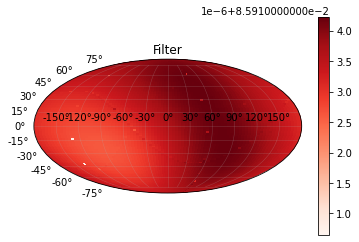

In [30]:
# Plot filter over sky locations

phi_plt = np.linspace(-np.pi, np.pi, num-1)
theta_plt = np.linspace(-np.pi/2., np.pi/2.,num-1)
Phi, Theta = np.meshgrid(phi_plt, theta_plt, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
im = ax.pcolormesh(Phi,Theta, filter_grid, cmap=plt.cm.Reds) 
plt.colorbar(im)
plt.title('Filter')
ax.grid(alpha=0.3, linewidth=0.5)
plt.show()

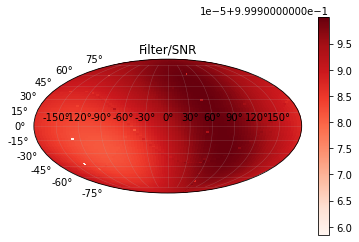

In [31]:
# Plot filter/true snr over sky

phi_plt = np.linspace(-np.pi, np.pi, num-1)
theta_plt = np.linspace(-np.pi/2., np.pi/2.,num-1)
Phi, Theta = np.meshgrid(phi_plt, theta_plt, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
im = ax.pcolormesh(Phi,Theta, filter_grid/true_snr, cmap=plt.cm.Reds) 
plt.colorbar(im)
plt.title('Filter/SNR')
ax.grid(alpha=0.3, linewidth=0.5)
plt.show()

In [32]:
# Overall match

max_filter = np.max(filter_grid)
rho_match = max_filter / true_snr

print(max_filter)
print(rho_match)

0.08591421811981935
0.9999999976627637


In [33]:
# Find parameters that give maximum filter response

max_skyindex = np.where(filter_grid == np.max(filter_grid))
max_skyindex_coords = list(zip(max_skyindex[0], max_skyindex[1])) # repacking into coordinate indexes
max_sky_coords = [(azimuths[1:][azim_index], poles[1:][pole_index]) 
                  for (azim_index, pole_index) in max_skyindex_coords]
max_az, max_po = max_sky_coords[0]

print(max_az, max_po)

max_psi, max_t0 = Functions.brute_max(Functions.filter_3, ranges_slice, npts, finish_fun,
                                      a, A, c, network, freqs, geocent, data, max_az, max_po, coord, keys, 0)[0]

print(max_psi, max_t0)

1.3766529605618194 1.870836074609652
0.31757239084364147 -0.01871268849889748


In [34]:
# store results for individual runs

# save parameters
run_results = {'match': rho_match, 
               'pole': max_po, 'azim':max_az,
               'psi': max_psi, 't0':max_t0
              }

current_dict[keys[0]] = run_results

# save filter grid array
np.savetxt(f"results/{list(true_kwargs.keys())[0]}_{keys[0]}.txt", filter_grid)

# Final results

In [35]:
# Convert results dictionary into dataframe

df = pd.DataFrame.from_dict(current_dict)
df

,true_params,hp,hx,hvx,hvy,hb
pole,0.785398,0.776573,0.776573,1.976732,1.870836,1.870836
azim,0.785398,0.811872,0.741275,1.447251,1.447251,1.376653
psi,0,1.065928,-1.027700,0.593587,1.893038,0.317572
t0,0,-0.000034,0.000307,-0.019360,-0.018893,-0.018713
geocent,0,NaN,NaN,NaN,NaN,NaN
modes,(hp),NaN,NaN,NaN,NaN,NaN
match,NaN,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
# Store final results for a set of true parameters

df.to_csv(f'results/{list(true_kwargs.keys())[0]}_true.csv', index=False)

In [160]:
df_read = pd.read_csv(f'results/group_2/{list(true_kwargs.keys())[0]}_true.csv')
df_read

,true_params,hp,hx,hvx,hvy,hb,hl
0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
1,0,-2.998793e+00,-1.285197e+00,2.427594e+00,-1.285197e+00,-2.998793,-2.998793
2,0,1.719361e+00,2.644034e+00,8.799604e-01,1.883784e+00,-0.000240,-0.000003
3,0,2.544781e-09,2.582252e-09,-9.181973e-07,-8.981619e-07,-0.000020,0.000006
4,0,NaN,NaN,NaN,NaN,NaN,NaN
5,dict_keys(['hp']),NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000
